**The problem was found** The model uses normalized patches to train and I was not normalizing patches when making the predictions.

In [1]:
from tomoSegmentPipeline.showcaseResults import (predict_fullTomogram, load_model, load_tomoData, Tversky_index,
                                        fullTomogram_modelComparison, make_comparison_plot, write_comparison_gif, save_classPred)

from tomoSegmentPipeline.losses import Tversky_loss
from tomoSegmentPipeline.utils.common import read_array
import tomoSegmentPipeline.dataloader as dl
from tomoSegmentPipeline.utils import setup
from tomoSegmentPipeline.dataloader import to_categorical, transpose_to_channels_first
from tomoSegmentPipeline.trainWrapper import make_trainer

PARENT_PATH = setup.PARENT_PATH

import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from glob import glob
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import torch
from tqdm import tqdm


%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

train_tomos = ['tomo02', 'tomo03', 'tomo17']
concat_train_ids = sorted([s.replace('tomo', '') for s in train_tomos])
concat_train_ids = '-'.join(concat_train_ids)

val_tomos = ['tomo10', 'tomo32']
concat_val_ids = sorted([s.replace('tomo', '') for s in val_tomos])
concat_val_ids = '-'.join(concat_val_ids)

test_tomos = ['tomo38', 'tomo04']
concat_test_ids = sorted([s.replace('tomo', '') for s in test_tomos])
concat_test_ids = '-'.join(concat_test_ids)

logs_path = PARENT_PATH + 'models_1/logs/BaselineModel/'
logs_path = Path(logs_path)


tomo_file_cryoCARE = '/home/haicu/jeronimo.carvajal/Thesis/data/nnUnet/nifti_files/%s_bin4_denoised_0000.nii.gz'
tomo_file_rawCET = '/home/haicu/jeronimo.carvajal/Thesis/data/raw_cryo-ET/%s.mrc'
tomo_file_isoNET = '/home/haicu/jeronimo.carvajal/Thesis/data/isoNet/RAW_dataset/RAW_corrected_i30/%s_corrected.mrc'
tomo_file_cryoCARE_isoNET = '/home/haicu/jeronimo.carvajal/Thesis/data/isoNet/cryoCARE_dataset/cryoCARE_corrected/%s_bin4_denoised_0000_corrected.mrc'

tomo_input_type_fileDict = {'rawCET':tomo_file_rawCET,
                            'cryoCARE': tomo_file_cryoCARE,
                            'isoNET': tomo_file_isoNET,
                            'cryoCARE+isoNET': tomo_file_cryoCARE_isoNET}

nCenters_dict = {'in56':28, 'in84':14, 'in96':11}

aux_label_file = '/home/haicu/jeronimo.carvajal/Thesis/data/nnUnet/nifti_files/%s_merged_thr02.nii.gz'

# Reproduce the problem

Prediction score on tomogram10 was unusually low

In [5]:
logs_path = PARENT_PATH + 'data/model_logs/models_1/logs/BaselineModel/'
logs_path = Path(logs_path)

model_info = []


for f in logs_path.rglob('*/version_*/'):
    logdir_path = f.as_posix()
    
    model_file = glob(os.path.join(logdir_path, '*.model'))
    if len(model_file)==1:
        model_file = model_file[0]
        
        model_file_split = model_file.split('/')
        
        input_type = model_file_split[-4]
        
        name, epochs, patch_size, lr, version = model_file_split[-1].split('_')
        epochs = int(epochs.replace('ep', ''))
        version = 'v'+version.replace('.model', '')

        events_path = glob(os.path.join(logdir_path, 'events.*'))[0]
        event_acc = EventAccumulator(events_path)
        event_acc.Reload()

        _, _, values_valLoss = zip(*event_acc.Scalars('hp/val_loss_epoch'))
        best_val_loss_epoch = np.min(values_valLoss)
        best_val_loss_epoch_idx = np.argmin(values_valLoss) #index starts count at 0

        effective_epochs = len(values_valLoss)

        _, _, values_dice = zip(*event_acc.Scalars('hp/val_dice_epoch'))
        _, _, values_trainLoss = zip(*event_acc.Scalars('hp/train_loss_epoch'))

        associated_val_class1_dice = float(values_dice[best_val_loss_epoch_idx])
        associated_train_loss_epoch = float(values_trainLoss[best_val_loss_epoch_idx])

        epochs_str = "%i out of %i" %(effective_epochs, 1000)

        model_info.append([name, model_file, input_type, epochs_str, patch_size, lr, version, best_val_loss_epoch, associated_val_class1_dice])
    
    else:
        pass
    
df_model = pd.DataFrame(model_info, columns=['name', 'model_file', 'input_type', 'epochs', 'patch_size', 'lr', 'version', 'best_val_loss_epoch',
                                             'associated_val_class1_dice'])
print(df_model.shape)
df_model.head()

(18, 9)


,name,model_file,input_type,epochs,patch_size,lr,version,best_val_loss_epoch,associated_val_class1_dice
0,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,cryoCARE+isoNET,386 out of 1000,in84,lr0.000100,v2,0.100280,0.909837
1,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,cryoCARE+isoNET,438 out of 1000,in84,lr0.000100,v1,0.092645,0.916506
2,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,cryoCARE+isoNET,238 out of 1000,in84,lr0.000100,v0,0.147336,0.866083
3,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,cryoCARE+isoNET,355 out of 1000,in84,lr0.000100,v3,0.095781,0.913784
4,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,cryoCARE,268 out of 1000,in56,lr0.000100,v2,0.126032,0.883435


In [6]:
bestModel_byType = df_model.loc[df_model.groupby('input_type').best_val_loss_epoch.idxmin()].reset_index(drop=True)
bestModel_byType

,name,model_file,input_type,epochs,patch_size,lr,version,best_val_loss_epoch,associated_val_class1_dice
0,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,cryoCARE,268 out of 1000,in56,lr0.000100,v2,0.126032,0.883435
1,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,cryoCARE+isoNET,438 out of 1000,in84,lr0.000100,v1,0.092645,0.916506
2,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,isoNET,472 out of 1000,in84,lr0.000100,v1,0.177506,0.840685
3,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,rawCET,215 out of 1000,in84,lr0.000300,v0,0.205240,0.820816


In [45]:
aux_label_file = '/home/haicu/jeronimo.carvajal/Thesis/data/nnUnet/nifti_files/%s_merged_thr02.nii.gz'

dice1_test_bestModels = []

for i, row in bestModel_byType[bestModel_byType.input_type=='cryoCARE+isoNET'].iterrows():
    model_fileList = [row['model_file']]
    n_centers_list = [nCenters_dict[row['patch_size']]]
    
    input_type = row['input_type']
    
    dice1_score = []

    for tomo in ['tomo10']:
        tomo_file = tomo_input_type_fileDict[input_type] %tomo
        label_file = aux_label_file %tomo
        class1_predDict, dice1_dict, class1, tomogram_data = fullTomogram_modelComparison(model_fileList, n_centers_list, tomo_file, 
                                                                                          label_file, overwrite_prediction=True, is_model_data=False)
        
        val = float(list(dice1_dict.items())[0][1][1])
        dice1_score.append(val)
        
    print(input_type)
    print('Model predictions on validation set: \n', dice1_score, '\n\n')
    dice1_test_bestModels.append(np.nanmean(dice1_score))

Predicting full tomogram using 14 centers...


100%|██████████| 1372/1372 [01:05<00:00, 20.91it/s]


cryoCARE+isoNET
Model predictions on validation set: 
 [0.00033809474552981555] 




# Make sure the tomogram prediction works on the patches

It seems that the problems is on predicting the full tomogram. Let's try to predict a patch first and see if it works as we expect.

In [54]:
paths_valData, paths_valTarget = setup.get_paths(['tomo10'], input_type)
tomo_file, label_file = paths_valData[0], paths_valTarget[0]
tomo_file, label_file

('/home/haicu/jeronimo.carvajal/Thesis/data/isoNet/cryoCARE_dataset/cryoCARE_corrected/patch_creation/result/Task511_cryoET/imagesTr/tomo10_patch001_0000.nii.gz',
 '/home/haicu/jeronimo.carvajal/Thesis/data/nnUnet/Task143_cryoET7/labelsTr/tomo10_patch001.nii.gz')

In [56]:
model_fileList = ['/home/haicu/jeronimo.carvajal/Thesis/data/model_logs/models_1/logs/BaselineModel/cryoCARE+isoNET/train02-03-17/version_1/Baseline_ep1000_in84_lr0.000100_1.model']
n_centers_list = [2]

In [61]:
class1_predDict, dice1_dict, class1, tomogram_data = fullTomogram_modelComparison(model_fileList, n_centers_list, tomo_file, label_file,
                                                                                  overwrite_prediction=True, is_model_data=True)

Predicting full tomogram using 2 centers...


100%|██████████| 8/8 [00:00<00:00, 21.71it/s]


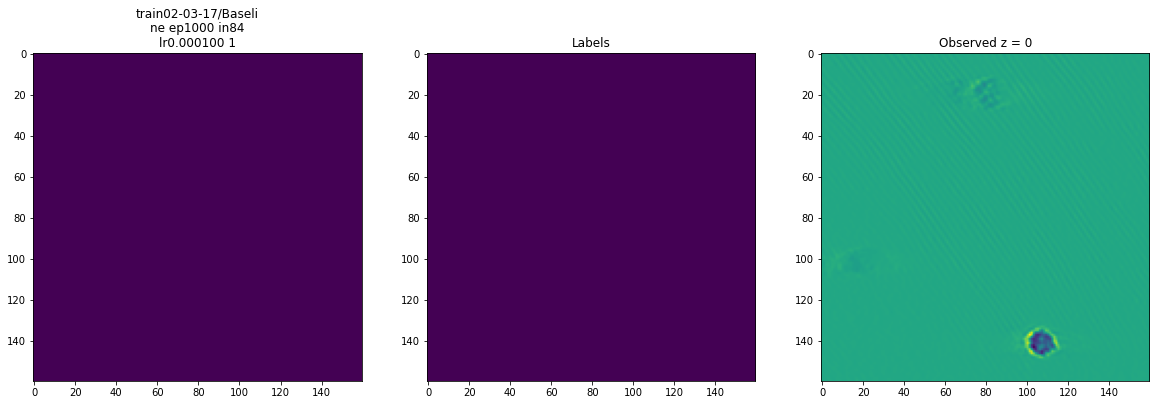

<Figure size 432x288 with 0 Axes>

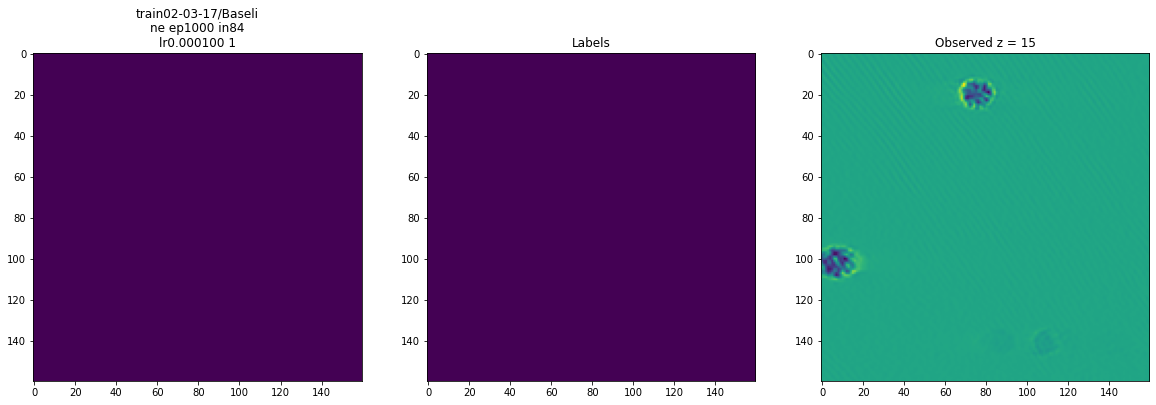

<Figure size 432x288 with 0 Axes>

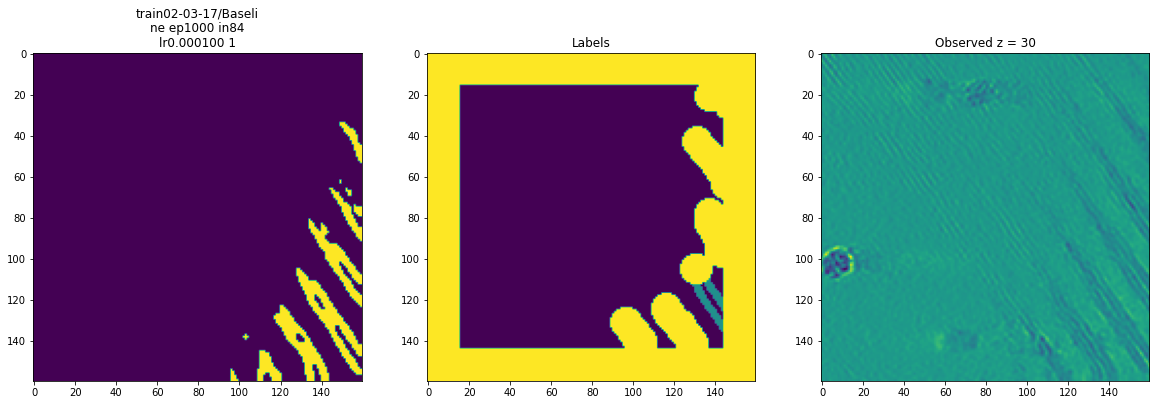

<Figure size 432x288 with 0 Axes>

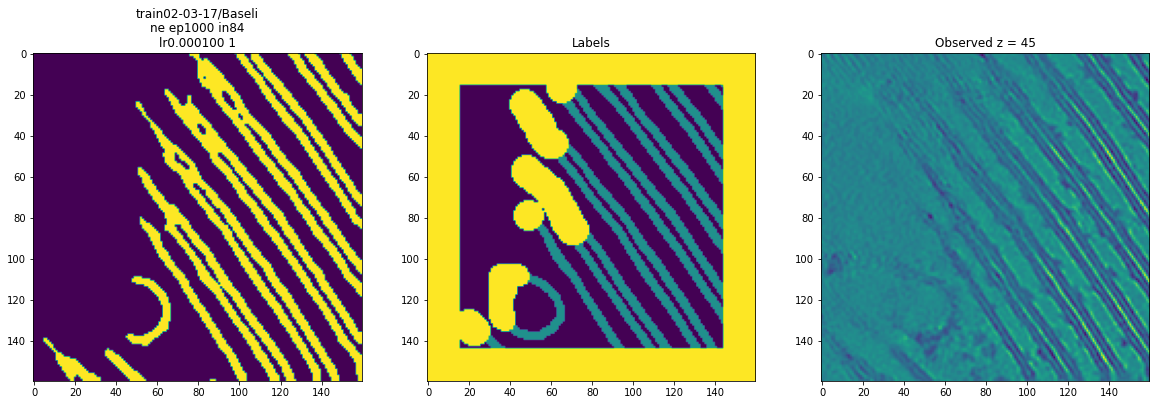

<Figure size 432x288 with 0 Axes>

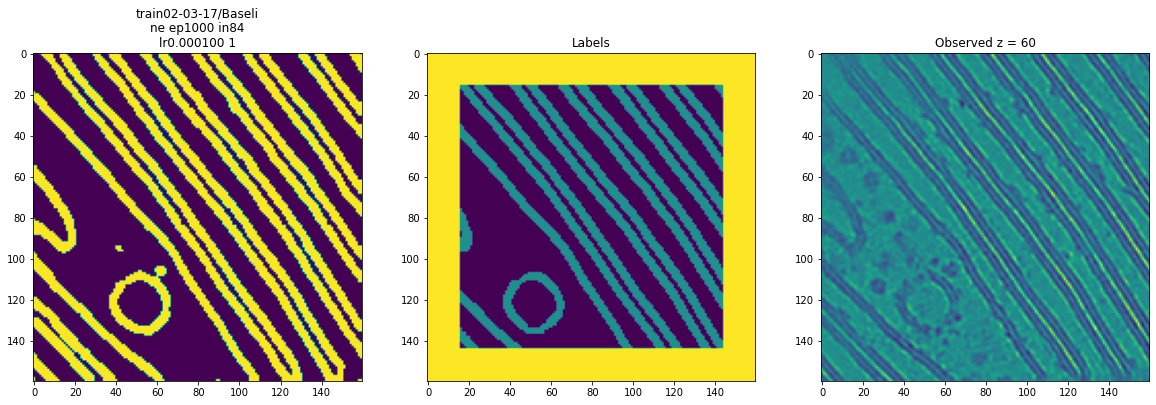

<Figure size 432x288 with 0 Axes>

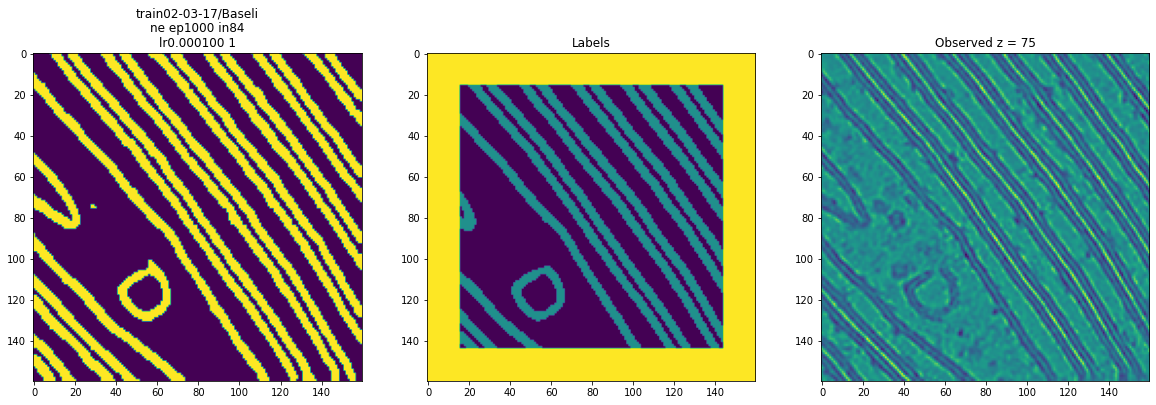

<Figure size 432x288 with 0 Axes>

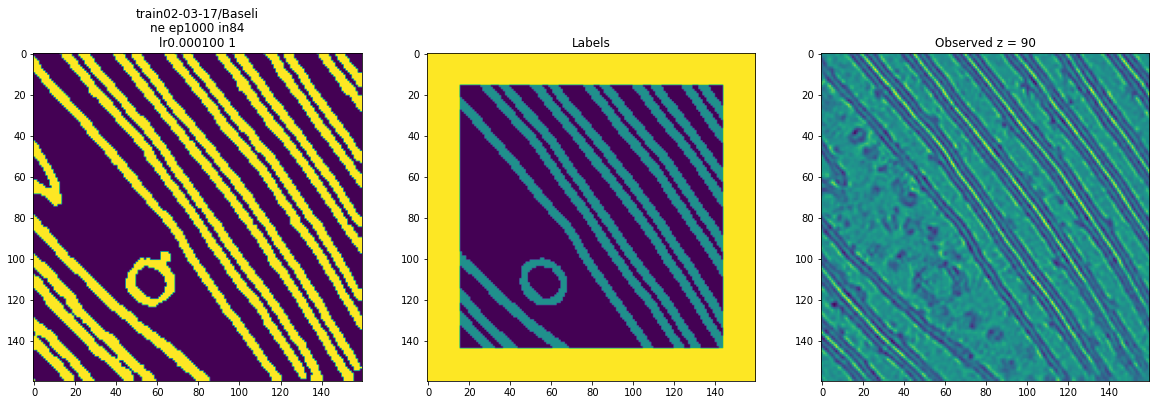

<Figure size 432x288 with 0 Axes>

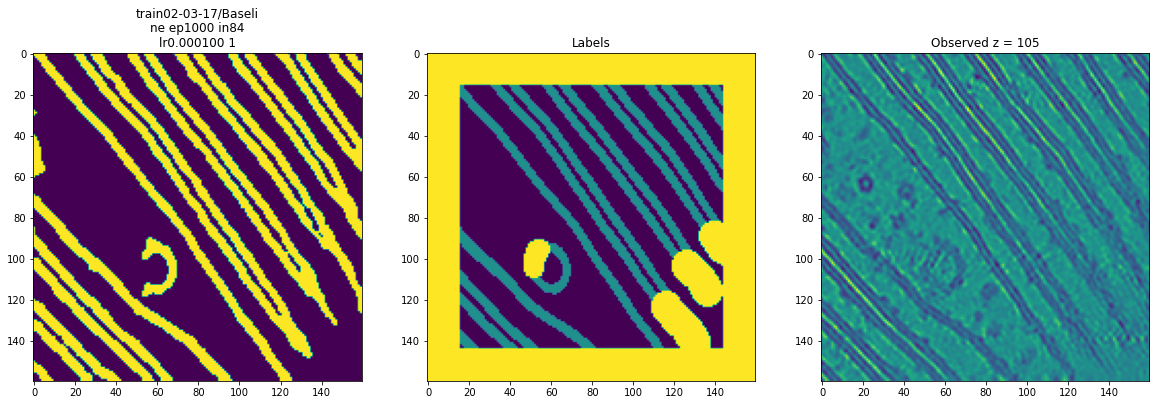

<Figure size 432x288 with 0 Axes>

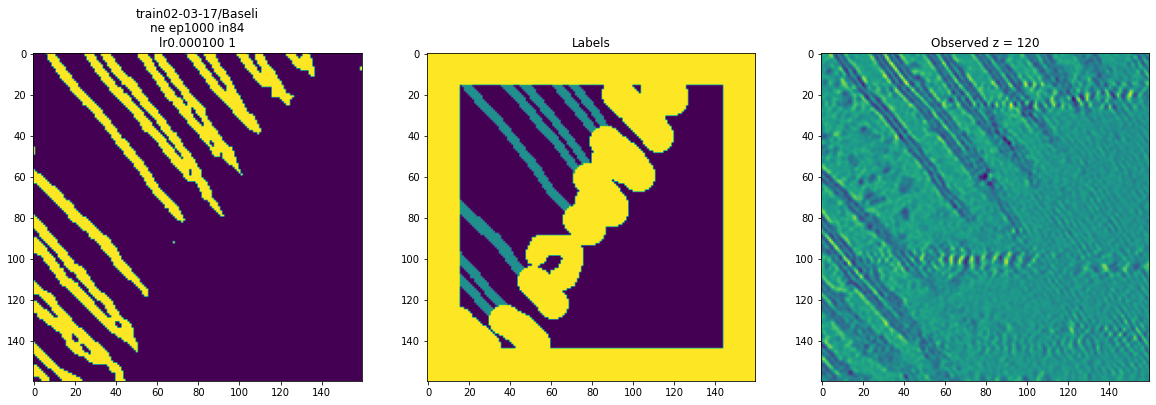

<Figure size 432x288 with 0 Axes>

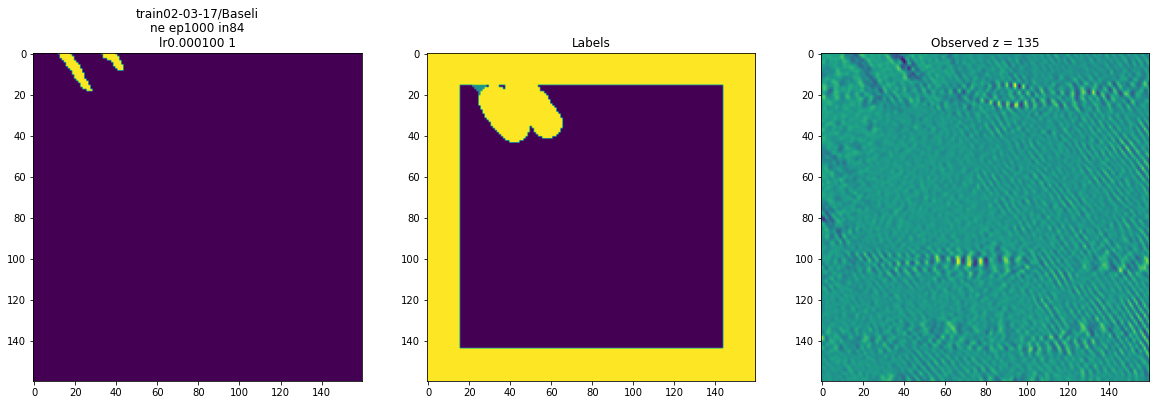

<Figure size 432x288 with 0 Axes>

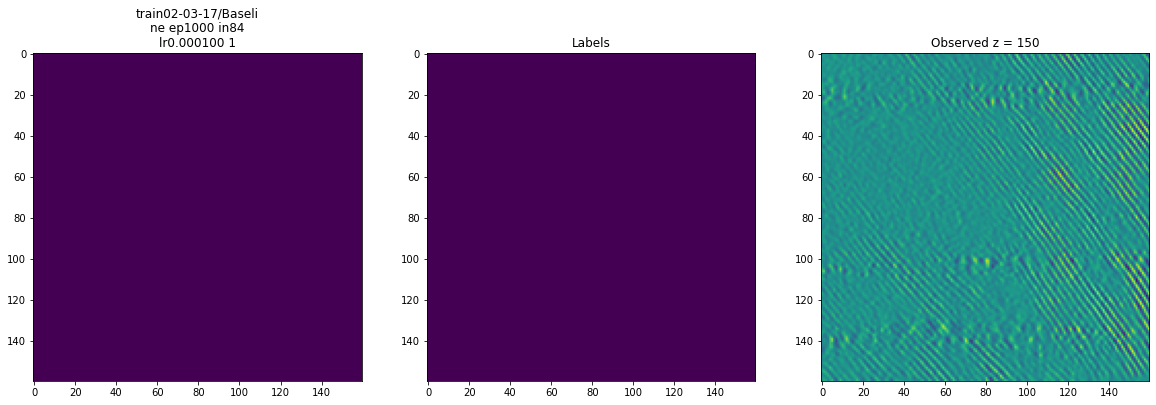

<Figure size 432x288 with 0 Axes>

In [63]:
make_comparison_plot(class1_predDict, class1, tomogram_data)

Results seem reasonable.

# Step by step breakdown to assess problem

I need to predict the full tomogram step by step and see where things are going wrong

In [30]:
my_tomo = 'tomo10'
label_file = '/home/haicu/jeronimo.carvajal/Thesis/data/nnUnet/nifti_files/%s_merged_thr02.nii.gz' %my_tomo

tomo_file = '/home/haicu/jeronimo.carvajal/Thesis/data/isoNet/cryoCARE_dataset/cryoCARE_corrected/%s_bin4_denoised_0000_corrected.mrc' %my_tomo
model_file = '/home/haicu/jeronimo.carvajal/Thesis/data/model_logs/models_1/logs/BaselineModel/cryoCARE+isoNET/train02-03-17/version_1/Baseline_ep1000_in84_lr0.000100_1.model'

# tomo_file = '/home/haicu/jeronimo.carvajal/Thesis/data/isoNet/RAW_dataset/RAW_corrected_i30/tomo10_corrected.mrc'
# model_file = '/home/haicu/jeronimo.carvajal/Thesis/data/model_logs/models_1/logs/BaselineModel/isoNET/train02-03-17/version_1/Baseline_ep1000_in84_lr0.000100_1.model'


n_centers = 14
dim_in = 84
Nclass = 2

tomogram_data, labels = load_tomoData(tomo_file, label_file, is_model_data=False)

model = load_model(model_file, Nclass)

In [31]:
zyx = tomogram_data.shape # tomogram dimensions
ref_dim = max(zyx)
l = int(dim_in/2) # size from center

pcenters = []
overlaps = []
for i in zyx:

    factor = i/ref_dim
    new_n_centers = int(np.round(factor*n_centers))
    pcenter = np.linspace(l, i-l, new_n_centers, dtype=int)

    pcenters.append(pcenter)
    overlaps.append(pcenter[0] - pcenter[1] + 2*l)

# Assert that the whole tomogram is covered and there is at least some overlapping.
# Z, Y, X
if all(np.array(overlaps)>l):
    print(overlaps)
    raise ValueError("There is too much overlap between patches. Reduce the number of centers.")

if not any(np.array(overlaps)>0):
    print(overlaps)
    raise ValueError('Current patches do not cover the full tomogram. Specify a larger number of centers.')

z, y, x = zyx
z, y, x

(464, 928, 928)

In [32]:
# pcenters

In [33]:
pred_tomo = torch.zeros((1, Nclass, z, y, x)).detach()
count_tensor = torch.zeros((1, Nclass, z, y, x)).detach() # for average normalization of overlapping patches

total_iterations = len(pcenters[0])*len(pcenters[1])*len(pcenters[2])

# print('Predicting full tomogram using %i centers...' %n_centers)
# with tqdm(total=total_iterations) as pbar:
#     for i in pcenters[0]:
#         for j in pcenters[1]:
#             for k in pcenters[2]:
for i, j, k in [[232, 847, 586]]:
                patch = tomogram_data[i-l:i+l, j-l:j+l, k-l:k+l]
                patch = torch.as_tensor(patch).unsqueeze(0).unsqueeze(0).to("cuda")

                model.eval()
                with torch.no_grad():
                    pred_patch = model(patch)
                    pred_patch = pred_patch.to("cpu")

                pred_tomo[:, :, i-l:i+l, j-l:j+l, k-l:k+l] += pred_patch
                count_tensor[:, :, i-l:i+l, j-l:j+l, k-l:k+l] += 1
                # pbar.update(1)

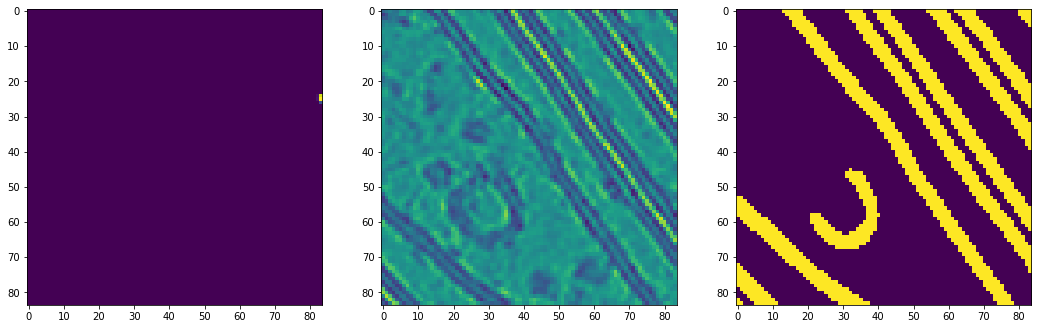

In [35]:
# tomo 10
label_patch = labels[i-l:i+l, j-l:j+l, k-l:k+l]
patch = tomogram_data[i-l:i+l, j-l:j+l, k-l:k+l]
aux = pred_patch.squeeze()

fig, ax = plt.subplots(1, 3, figsize=(18, 15))

ax[0].imshow(aux[1][42])
ax[1].imshow(patch[42])
ax[2].imshow(label_patch[42])

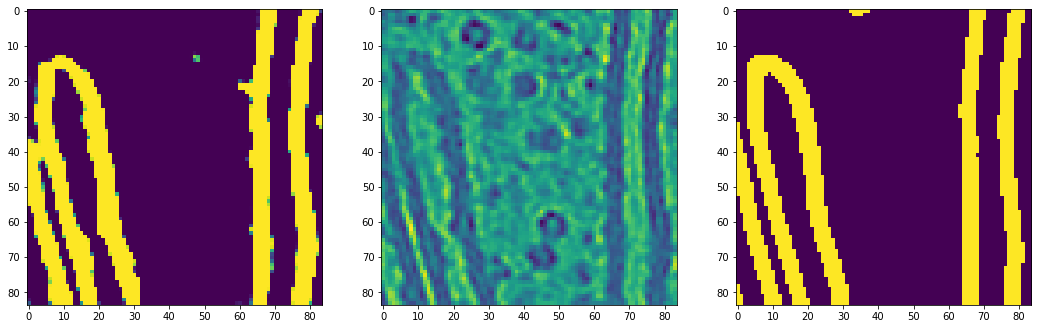

In [61]:
# tomo32
label_patch = labels[i-l:i+l, j-l:j+l, k-l:k+l]
patch = tomogram_data[i-l:i+l, j-l:j+l, k-l:k+l]
aux = pred_patch.squeeze()

fig, ax = plt.subplots(1, 3, figsize=(18, 15))

ax[0].imshow(aux[1][42])
ax[1].imshow(patch[42])
ax[2].imshow(label_patch[42])

# Explore patch distributions to see if tomo10 has something fundamentally different from the rest

## Full tomograms

Doesn't seem to be much difference

In [63]:
# label_file = '/home/haicu/jeronimo.carvajal/Thesis/data/nnUnet/nifti_files/%s_merged_thr02.nii.gz' %my_tomo
tomo10 = '/home/haicu/jeronimo.carvajal/Thesis/data/isoNet/cryoCARE_dataset/cryoCARE_corrected/tomo10_bin4_denoised_0000_corrected.mrc'
tomo10, _ = load_tomoData(tomo10, label_file, is_model_data=False)

tomo32 = '/home/haicu/jeronimo.carvajal/Thesis/data/isoNet/cryoCARE_dataset/cryoCARE_corrected/tomo32_bin4_denoised_0000_corrected.mrc'
tomo32, _ = load_tomoData(tomo32, label_file, is_model_data=False)

tomo17 = '/home/haicu/jeronimo.carvajal/Thesis/data/isoNet/cryoCARE_dataset/cryoCARE_corrected/tomo17_bin4_denoised_0000_corrected.mrc'
tomo17, _ = load_tomoData(tomo17, label_file, is_model_data=False)

(array([3.40000000e+01, 5.58000000e+02, 4.30800000e+03, 1.26400000e+04,
        1.88170000e+04, 2.27587000e+05, 3.99306427e+08, 1.68400000e+04,
        2.01300000e+03, 1.52000000e+02]),
 array([-30.815807 , -25.98052  , -21.145233 , -16.309946 , -11.474658 ,
         -6.639371 ,  -1.8040836,   3.0312037,   7.866491 ,  12.701778 ,
         17.537066 ], dtype=float32),
 <BarContainer object of 10 artists>)

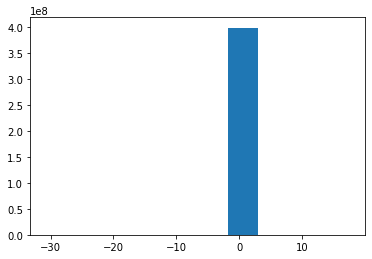

In [65]:
plt.hist(tomo10.flatten())

(array([7.0000000e+00, 1.9000000e+01, 4.4000000e+01, 1.0400000e+02,
        3.2900000e+02, 5.4920000e+03, 3.9304867e+08, 6.5315310e+06,
        3.1200000e+03, 6.0000000e+01]),
 array([-29.43582   , -25.193262  , -20.950705  , -16.708145  ,
        -12.465588  ,  -8.22303   ,  -3.980472  ,   0.26208574,
          4.5046434 ,   8.747202  ,  12.989759  ], dtype=float32),
 <BarContainer object of 10 artists>)

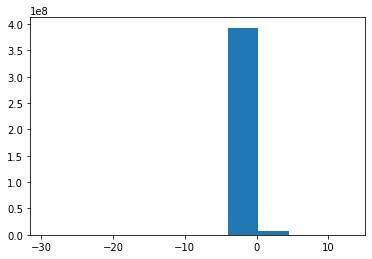

In [66]:
plt.hist(tomo32.flatten())

(array([1.10000000e+01, 3.60000000e+01, 1.85000000e+02, 3.60000000e+02,
        8.21000000e+02, 2.54400000e+03, 1.30820566e+08, 2.68764239e+08,
        5.84000000e+02, 3.00000000e+01]),
 array([-33.512337  , -28.806284  , -24.10023   , -19.394176  ,
        -14.688122  ,  -9.982069  ,  -5.276015  ,  -0.56996125,
          4.136092  ,   8.842146  ,  13.5482    ], dtype=float32),
 <BarContainer object of 10 artists>)

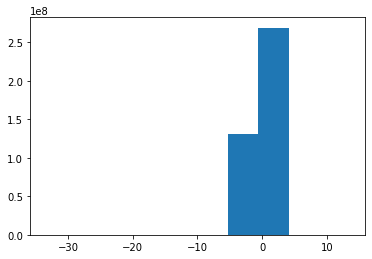

In [67]:
plt.hist(tomo17.flatten())

## Patches

Try to match the tomogram data with the patch data and compare model behavior

In [2]:
n_centers = 2
dim_in = 84
Nclass = 2

model_file = '/home/haicu/jeronimo.carvajal/Thesis/data/model_logs/models_1/logs/BaselineModel/cryoCARE+isoNET/train02-03-17/version_1/Baseline_ep1000_in84_lr0.000100_1.model'
model = load_model(model_file, Nclass)

paths_valData, paths_valTarget = setup.get_paths(['tomo10'], 'cryoCARE+isoNET')
patch_file, patch_label_file = paths_valData[0], paths_valTarget[0]

patch_data, patch_labels = load_tomoData(patch_file, patch_label_file, is_model_data=True)

zyx = patch_data.shape # tomogram dimensions
ref_dim = max(zyx)
l = int(dim_in/2) # size from center

pcenters = []
overlaps = []
for i in zyx:

    factor = i/ref_dim
    new_n_centers = int(np.round(factor*n_centers))
    pcenter = np.linspace(l, i-l, new_n_centers, dtype=int)

    pcenters.append(pcenter)
    overlaps.append(pcenter[0] - pcenter[1] + 2*l)

# Assert that the whole tomogram is covered and there is at least some overlapping.
# Z, Y, X
if all(np.array(overlaps)>l):
    print(overlaps)
    raise ValueError("There is too much overlap between patches. Reduce the number of centers.")

if not any(np.array(overlaps)>0):
    print(overlaps)
    raise ValueError('Current patches do not cover the full tomogram. Specify a larger number of centers.')

z, y, x = zyx

pred_tomo_patch = torch.zeros((1, Nclass, z, y, x)).detach()
count_tensor = torch.zeros((1, Nclass, z, y, x)).detach() # for average normalization of overlapping patches

total_iterations = len(pcenters[0])*len(pcenters[1])*len(pcenters[2])

# print('Predicting full tomogram using %i centers...' %n_centers)
# with tqdm(total=total_iterations) as pbar:
#     for i in pcenters[0]:
#         for j in pcenters[1]:
#             for k in pcenters[2]:
for i, j, k in [[80, 80, 80]]:
                patch = patch_data[i-l:i+l, j-l:j+l, k-l:k+l]
                patch = torch.as_tensor(patch).unsqueeze(0).unsqueeze(0).to("cuda")

                model.eval()
                with torch.no_grad():
                    pred_patch = model(patch)
                    pred_patch = pred_patch.to("cpu")

                pred_tomo_patch[:, :, i-l:i+l, j-l:j+l, k-l:k+l] += pred_patch
                count_tensor[:, :, i-l:i+l, j-l:j+l, k-l:k+l] += 1
                # pbar.update(1)

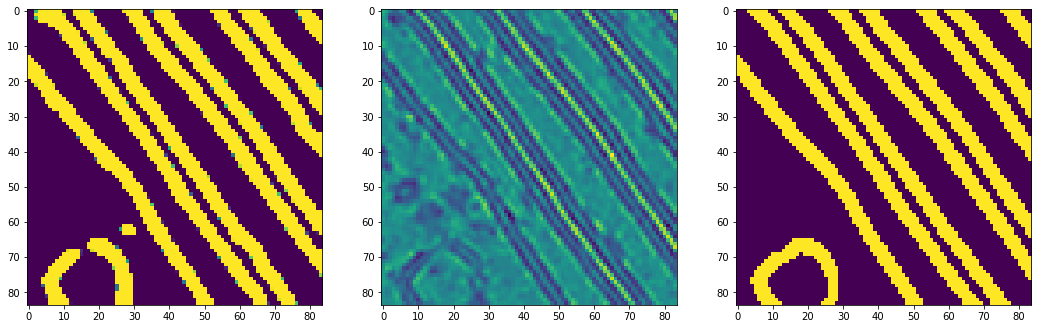

In [11]:

label_minipatch = patch_labels[i-l:i+l, j-l:j+l, k-l:k+l]
minipatch = patch_data[i-l:i+l, j-l:j+l, k-l:k+l]
aux = pred_tomo_patch[:, :, i-l:i+l, j-l:j+l, k-l:k+l].squeeze()

fig, ax = plt.subplots(1, 3, figsize=(18, 15))

ax[0].imshow(aux[1][42])
ax[1].imshow(minipatch[42])
ax[2].imshow(label_minipatch[42])

In [21]:
my_tomo = 'tomo10'
label_file = '/home/haicu/jeronimo.carvajal/Thesis/data/nnUnet/nifti_files/%s_merged_thr02.nii.gz' %my_tomo

tomo_file = '/home/haicu/jeronimo.carvajal/Thesis/data/isoNet/cryoCARE_dataset/cryoCARE_corrected/%s_bin4_denoised_0000_corrected.mrc' %my_tomo
model_file = '/home/haicu/jeronimo.carvajal/Thesis/data/model_logs/models_1/logs/BaselineModel/cryoCARE+isoNET/train02-03-17/version_1/Baseline_ep1000_in84_lr0.000100_1.model'

n_centers = 14
dim_in = 84
Nclass = 2

tomogram_data, labels = load_tomoData(tomo_file, label_file, is_model_data=False)

model = load_model(model_file, Nclass)

zyx = tomogram_data.shape # tomogram dimensions
ref_dim = max(zyx)
l = int(dim_in/2) # size from center

pcenters = []
overlaps = []
for i in zyx:

    factor = i/ref_dim
    new_n_centers = int(np.round(factor*n_centers))
    pcenter = np.linspace(l, i-l, new_n_centers, dtype=int)

    pcenters.append(pcenter)
    overlaps.append(pcenter[0] - pcenter[1] + 2*l)

# Assert that the whole tomogram is covered and there is at least some overlapping.
# Z, Y, X
if all(np.array(overlaps)>l):
    print(overlaps)
    raise ValueError("There is too much overlap between patches. Reduce the number of centers.")

if not any(np.array(overlaps)>0):
    print(overlaps)
    raise ValueError('Current patches do not cover the full tomogram. Specify a larger number of centers.')

z, y, x = zyx
z, y, x

# pcenters

pred_tomo = torch.zeros((1, Nclass, z, y, x)).detach()
count_tensor = torch.zeros((1, Nclass, z, y, x)).detach() # for average normalization of overlapping patches

total_iterations = len(pcenters[0])*len(pcenters[1])*len(pcenters[2])

# print('Predicting full tomogram using %i centers...' %n_centers)
# with tqdm(total=total_iterations) as pbar:
#     for i in pcenters[0]:
#         for j in pcenters[1]:
#             for k in pcenters[2]:
for i, j, k in [[232, 847, 586]]:
                patch = tomogram_data[i-l:i+l, j-l:j+l, k-l:k+l]
                patch = torch.as_tensor(patch).unsqueeze(0).unsqueeze(0).to("cuda")
            
                patch = (patch - torch.mean(patch)) / torch.std(patch)

                model.eval()
                with torch.no_grad():
                    pred_patch = model(patch)
                    pred_patch = pred_patch.to("cpu")

                pred_tomo[:, :, i-l:i+l, j-l:j+l, k-l:k+l] += pred_patch
                count_tensor[:, :, i-l:i+l, j-l:j+l, k-l:k+l] += 1
                # pbar.update(1)

# predicting with all centers yields to well defined averages
# count_tensor.min(), count_tensor.max()
# (tensor(1.), tensor(8.))

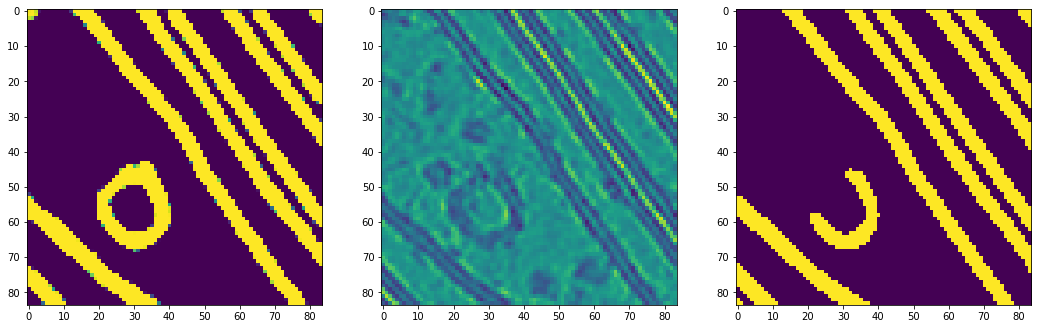

In [22]:
label_patch = labels[i-l:i+l, j-l:j+l, k-l:k+l]
patch = tomogram_data[i-l:i+l, j-l:j+l, k-l:k+l]
aux = pred_patch.squeeze()

fig, ax = plt.subplots(1, 3, figsize=(18, 15))

ax[0].imshow(aux[1][42])
ax[1].imshow(patch[42])
ax[2].imshow(label_patch[42])

(array([9.00000e+00, 1.80000e+01, 1.16000e+02, 1.73170e+04, 9.59100e+04,
        2.14852e+05, 2.19030e+05, 3.70400e+04, 7.85700e+03, 5.55000e+02]),
 array([-11.131682  ,  -9.2162285 ,  -7.3007736 ,  -5.3853197 ,
         -3.4698653 ,  -1.5544109 ,   0.36104336,   2.2764976 ,
          4.1919518 ,   6.107406  ,   8.022861  ], dtype=float32),
 <BarContainer object of 10 artists>)

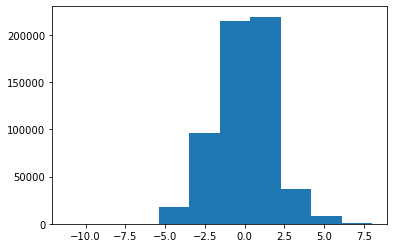

In [23]:
plt.hist(minipatch.flatten())

(array([5.00000e+00, 1.30000e+01, 9.60000e+01, 1.19930e+04, 6.95570e+04,
        2.12946e+05, 2.56849e+05, 3.44670e+04, 6.09000e+03, 6.88000e+02]),
 array([-3.8273644 , -3.2584498 , -2.689535  , -2.1206203 , -1.5517056 ,
        -0.9827908 , -0.41387612,  0.15503863,  0.72395337,  1.292868  ,
         1.8617828 ], dtype=float32),
 <BarContainer object of 10 artists>)

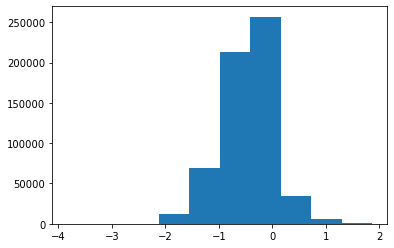

In [24]:
plt.hist(patch.flatten())

# Check if problem is solved by implementing patch normalization

In [2]:
logs_path = PARENT_PATH + 'data/model_logs/models_1/logs/BaselineModel/'
logs_path = Path(logs_path)

model_info = []


for f in logs_path.rglob('*/version_*/'):
    logdir_path = f.as_posix()
    
    model_file = glob(os.path.join(logdir_path, '*.model'))
    if len(model_file)==1:
        model_file = model_file[0]
        
        model_file_split = model_file.split('/')
        
        input_type = model_file_split[-4]
        
        name, epochs, patch_size, lr, version = model_file_split[-1].split('_')
        epochs = int(epochs.replace('ep', ''))
        version = 'v'+version.replace('.model', '')

        events_path = glob(os.path.join(logdir_path, 'events.*'))[0]
        event_acc = EventAccumulator(events_path)
        event_acc.Reload()

        _, _, values_valLoss = zip(*event_acc.Scalars('hp/val_loss_epoch'))
        best_val_loss_epoch = np.min(values_valLoss)
        best_val_loss_epoch_idx = np.argmin(values_valLoss) #index starts count at 0

        effective_epochs = len(values_valLoss)

        _, _, values_dice = zip(*event_acc.Scalars('hp/val_dice_epoch'))
        _, _, values_trainLoss = zip(*event_acc.Scalars('hp/train_loss_epoch'))

        associated_val_class1_dice = float(values_dice[best_val_loss_epoch_idx])
        associated_train_loss_epoch = float(values_trainLoss[best_val_loss_epoch_idx])

        epochs_str = "%i out of %i" %(effective_epochs, 1000)

        model_info.append([name, model_file, input_type, epochs_str, patch_size, lr, version, best_val_loss_epoch, associated_val_class1_dice])
    
    else:
        pass
    
df_model = pd.DataFrame(model_info, columns=['name', 'model_file', 'input_type', 'epochs', 'patch_size', 'lr', 'version', 'best_val_loss_epoch',
                                             'associated_val_class1_dice'])
print(df_model.shape)
df_model.head()

(18, 9)


,name,model_file,input_type,epochs,patch_size,lr,version,best_val_loss_epoch,associated_val_class1_dice
0,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,cryoCARE+isoNET,386 out of 1000,in84,lr0.000100,v2,0.100280,0.909837
1,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,cryoCARE+isoNET,438 out of 1000,in84,lr0.000100,v1,0.092645,0.916506
2,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,cryoCARE+isoNET,238 out of 1000,in84,lr0.000100,v0,0.147336,0.866083
3,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,cryoCARE+isoNET,355 out of 1000,in84,lr0.000100,v3,0.095781,0.913784
4,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,cryoCARE,268 out of 1000,in56,lr0.000100,v2,0.126032,0.883435


In [3]:
bestModel_byType = df_model.loc[df_model.groupby('input_type').best_val_loss_epoch.idxmin()].reset_index(drop=True)
bestModel_byType

,name,model_file,input_type,epochs,patch_size,lr,version,best_val_loss_epoch,associated_val_class1_dice
0,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,cryoCARE,268 out of 1000,in56,lr0.000100,v2,0.126032,0.883435
1,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,cryoCARE+isoNET,438 out of 1000,in84,lr0.000100,v1,0.092645,0.916506
2,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,isoNET,472 out of 1000,in84,lr0.000100,v1,0.177506,0.840685
3,Baseline,/home/haicu/jeronimo.carvajal/Thesis/data/mode...,rawCET,215 out of 1000,in84,lr0.000300,v0,0.205240,0.820816


In [4]:
aux_label_file = '/home/haicu/jeronimo.carvajal/Thesis/data/nnUnet/nifti_files/%s_merged_thr02.nii.gz'

dice1_test_bestModels = []

for i, row in bestModel_byType[bestModel_byType.input_type=='cryoCARE+isoNET'].iterrows():
    model_fileList = [row['model_file']]
    n_centers_list = [nCenters_dict[row['patch_size']]]
    
    input_type = row['input_type']
    
    dice1_score = []

    for tomo in ['tomo10']:
        tomo_file = tomo_input_type_fileDict[input_type] %tomo
        label_file = aux_label_file %tomo
        class1_predDict, dice1_dict, class1, tomogram_data = fullTomogram_modelComparison(model_fileList, n_centers_list, tomo_file, 
                                                                                          label_file, overwrite_prediction=True, is_model_data=False)
        
        val = float(list(dice1_dict.items())[0][1][1])
        dice1_score.append(val)
        
    print(input_type)
    print('Model predictions on validation set: \n', dice1_score, '\n\n')
    dice1_test_bestModels.append(np.nanmean(dice1_score))

Predicting full tomogram using 14 centers...


100%|██████████| 1372/1372 [01:08<00:00, 20.00it/s]


cryoCARE+isoNET
Model predictions on validation set: 
 [0.7343910336494446] 


